In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,root_mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries#to read our time series pandas dataframe
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler#scalin our data
from darts.models import RNNModel
import tqdm as notebook_tqdm

In [39]:
df = pd.read_csv('nyc_data.csv',index_col='Date',parse_dates=True)
df.head()

,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2015-01-01,720.000885,0,0,0,3.68,41.305
2015-01-02,581.276773,0,0,0,4.73,131.574
2015-01-03,754.117039,0,0,0,7.23,162.700
2015-01-04,622.252774,0,0,0,10.96,160.281
2015-01-05,785.373319,0,0,0,6.92,51.077


In [40]:
df = df.rename(columns={'Demand':'y'})

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2015-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   y             2192 non-null   float64
 1   Easter        2192 non-null   int64  
 2   Thanksgiving  2192 non-null   int64  
 3   Christmas     2192 non-null   int64  
 4   Temperature   2192 non-null   float64
 5   Marketing     2192 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 119.9 KB


In [42]:
df=df.asfreq("D")

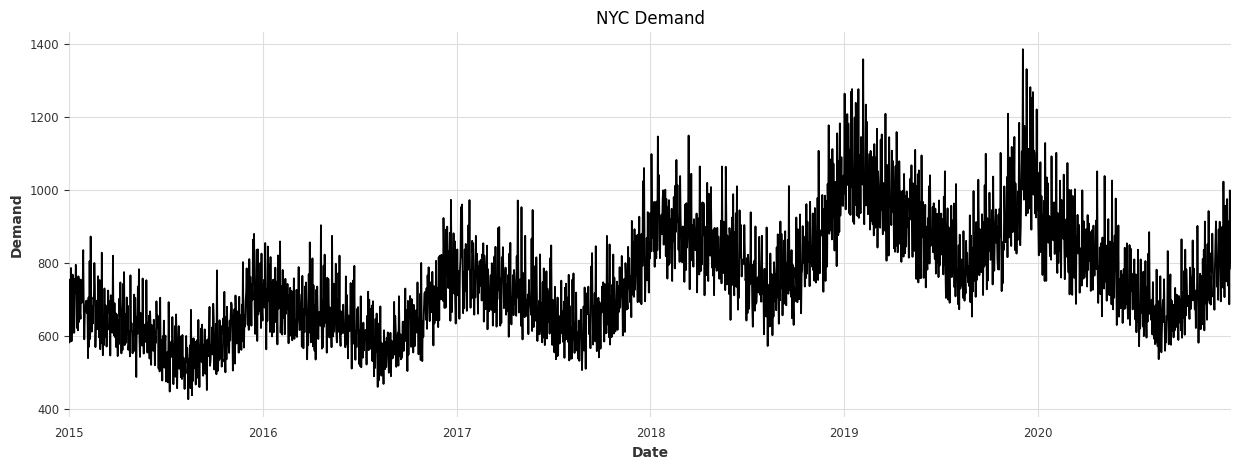

In [43]:
df['y'].plot(figsize=(15,5),title='NYC Demand',ylabel='Demand',xlabel='Date')
plt.show()

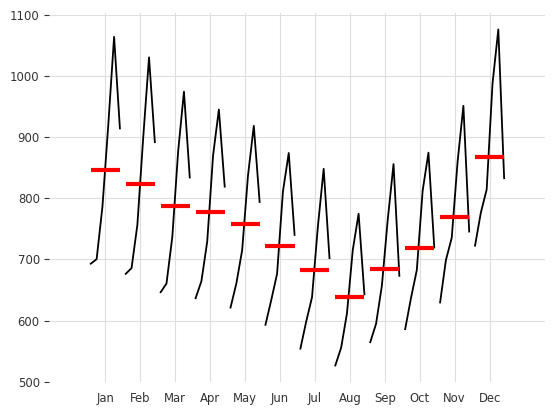

In [44]:
month_plot(df['y'].resample('ME').mean())
plt.show()

/var/folders/34/g14jtby103n5d93zf7cbk1580000gn/T/ipykernel_96474/2580449719.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(df['y'].resample('Q').mean())


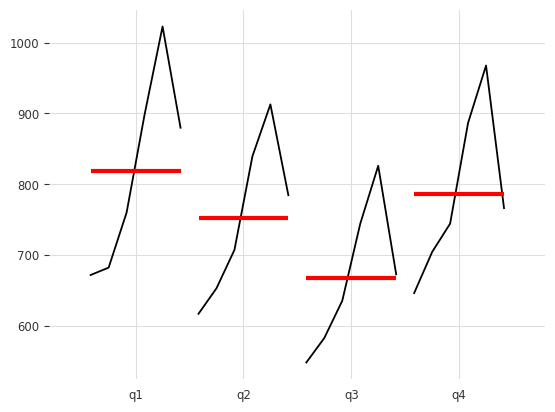

In [45]:
quarter_plot(df['y'].resample('Q').mean())  
plt.show()

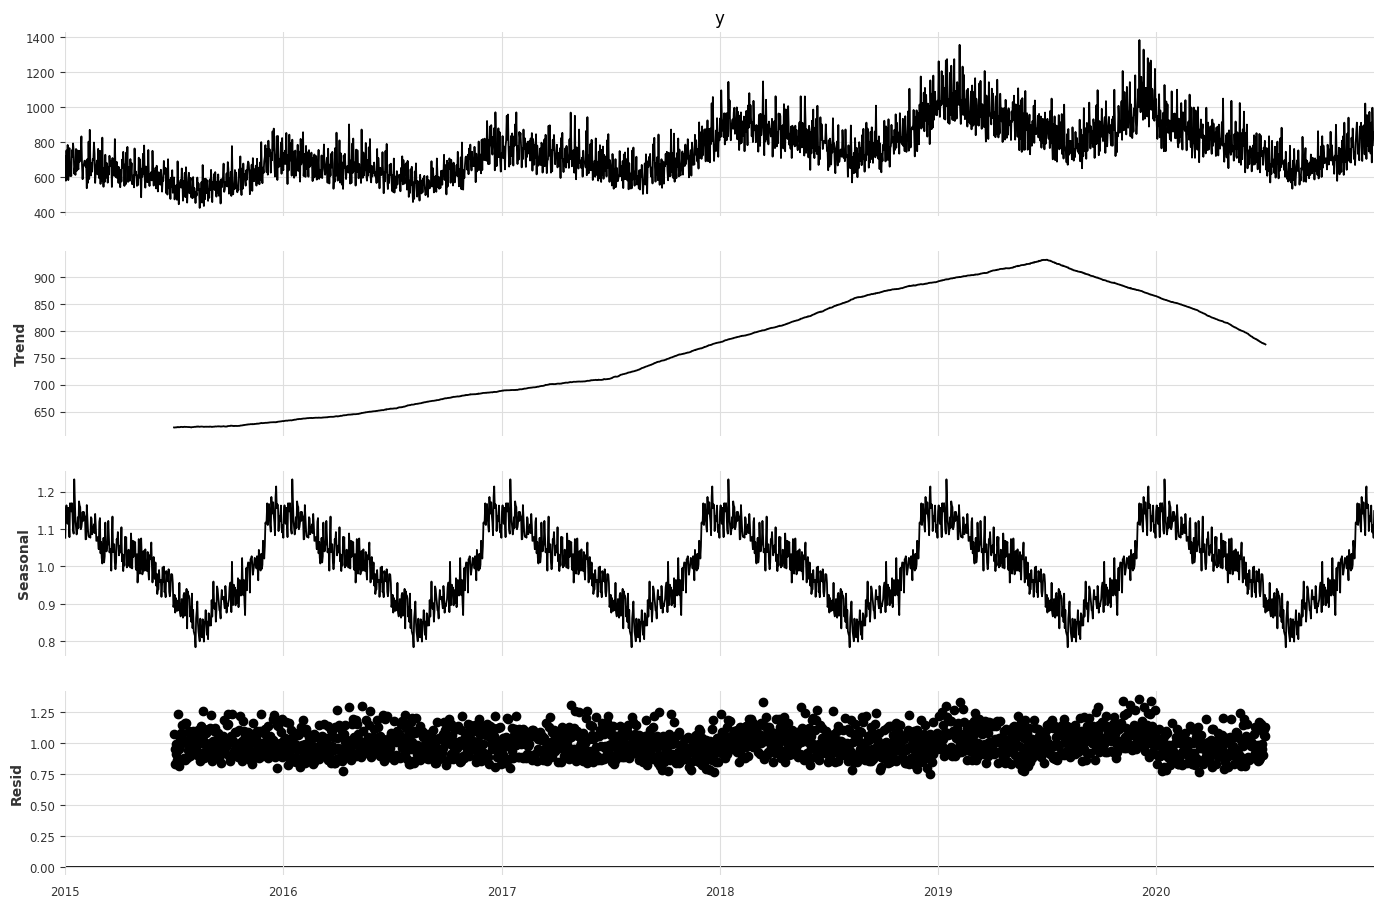

In [46]:
decomposition=seasonal_decompose(df['y'],model='mul',period=365)
fig=decomposition.plot()
fig.set_size_inches(15,10)
plt.show()

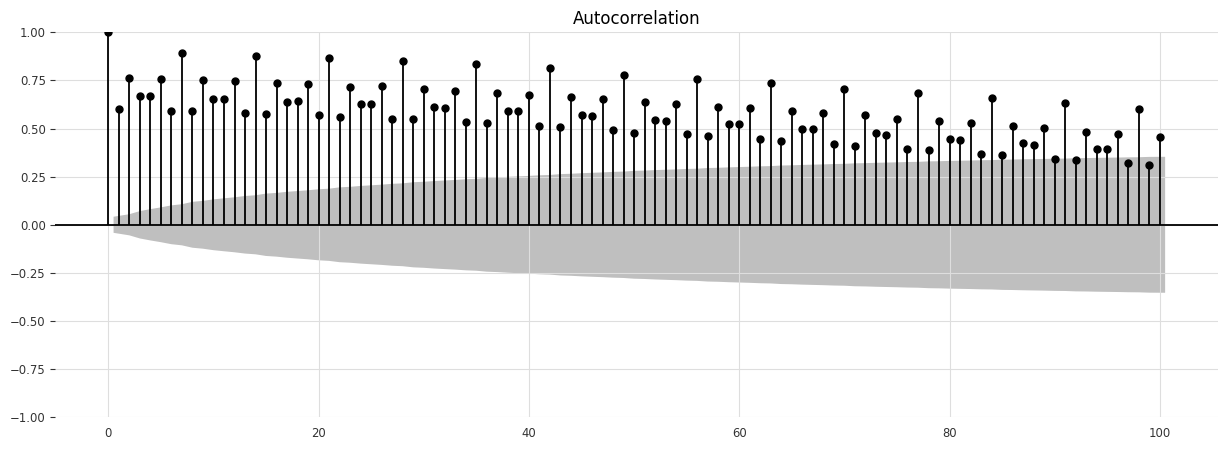

In [47]:
fig,ax =plt.subplots(figsize=(15,5))
plot_acf(df['y'],ax=ax,lags=100)
plt.show()


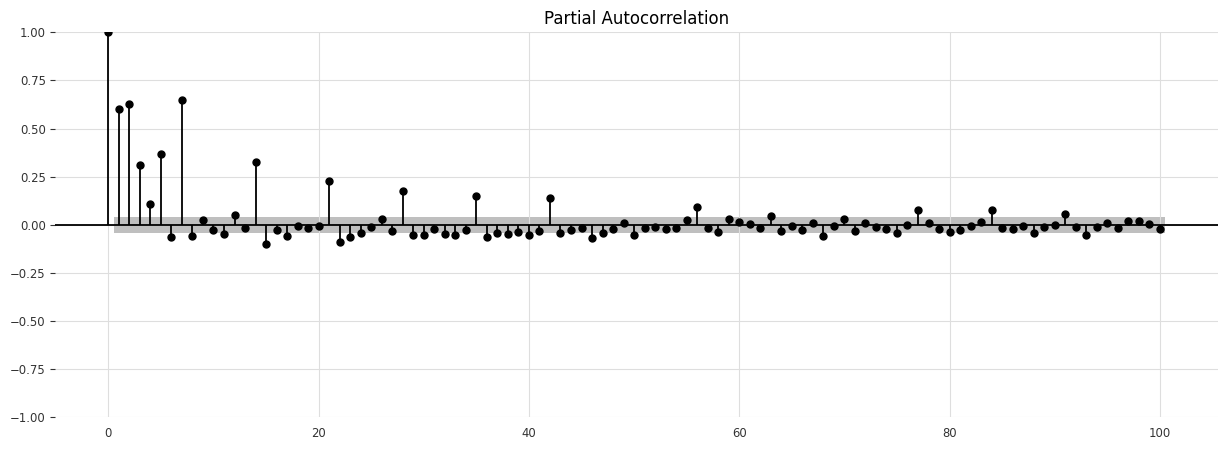

In [48]:
fig,ax =plt.subplots(figsize=(15,5))
plot_pacf(df['y'],ax=ax,lags=100)
plt.show()


In [49]:
#preparing our pandas data frame to deeplearing
series = TimeSeries.from_series(df.y)
covariates = TimeSeries.from_dataframe(df.drop(columns=['y']))
series.shape,covariates.shape

((2192, 1, 1), (2192, 5, 1))

In [50]:
series

<TimeSeries (DataArray) (Date: 2192, component: 1, sample: 1)> Size: 18kB
array([[[720.0008852]],

       [[581.2767734]],

       [[754.117039 ]],

       ...,

       [[847.1233994]],

       [[857.5210429]],

       [[783.8914943]]])
Coordinates:
  * Date       (Date) datetime64[ns] 18kB 2015-01-01 2015-01-02 ... 2020-12-31
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [51]:
covariates

<TimeSeries (DataArray) (Date: 2192, component: 5, sample: 1)> Size: 88kB
array([[[  0.   ],
        [  0.   ],
        [  0.   ],
        [  3.68 ],
        [ 41.305]],

       [[  0.   ],
        [  0.   ],
        [  0.   ],
        [  4.73 ],
        [131.574]],

       [[  0.   ],
        [  0.   ],
        [  0.   ],
        [  7.23 ],
        [162.7  ]],

       ...,

       [[  0.   ],
        [  0.   ],
        [  0.   ],
        [  3.48 ],
        [161.865]],

       [[  0.   ],
        [  0.   ],
        [  0.   ],
        [  5.97 ],
        [179.634]],

       [[  0.   ],
        [  0.   ],
        [  0.   ],
        [  8.22 ],
        [149.221]]])
Coordinates:
  * Date       (Date) datetime64[ns] 18kB 2015-01-01 2015-01-02 ... 2020-12-31
  * component  (component) object 40B 'Easter' 'Thanksgiving' ... 'Marketing'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [52]:
#becase we need more context on time series we split years , months,dtaa
#starting with our year series model
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                  freq = series.freq_str,
                  periods = df.shape[0]),
                  attribute = "year",
                  one_hot = False)
print(year_series[0])
month_series = datetime_attribute_timeseries(year_series,
                                             attribute = "month",
                                             one_hot = True)
print(month_series[0])
weekday_series = datetime_attribute_timeseries(year_series,
                                             attribute = "weekday",
                                             one_hot = True)
weekday_series[0]

<TimeSeries (DataArray) (time: 1, component: 1, sample: 1)> Size: 8B
array([[[2015.]]])
Coordinates:
  * time       (time) datetime64[ns] 8B 2015-01-01
  * component  (component) object 8B 'year'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (time: 1, component: 12, sample: 1)> Size: 96B
array([[[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * time       (time) datetime64[ns] 8B 2015-01-01
  * component  (component) object 96B 'month_0' 'month_1' ... 'month_11'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


<TimeSeries (DataArray) (time: 1, component: 7, sample: 1)> Size: 56B
array([[[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * time       (time) datetime64[ns] 8B 2015-01-01
  * component  (component) object 56B 'weekday_0' 'weekday_1' ... 'weekday_6'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [53]:
#befoire added we need to scale our data
scaler1 = Scaler()
scaler2 = Scaler()


In [54]:
y_transformed = scaler1.fit_transform(series)

In [55]:
covariates = covariates.stack(year_series)
covariates_transformed = scaler2.fit_transform(covariates)
covariates_transformed = covariates_transformed.stack(month_series)
covariates_transformed = covariates_transformed.stack(weekday_series)
covariates_transformed[0]

<TimeSeries (DataArray) (Date: 1, component: 25, sample: 1)> Size: 200B
array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.31522013],
        [0.06072561],
        [0.        ],
        [1.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [1.        ],
        [0.        ],
        [0.        ],
        [0.        ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 8B 2015-01-01
  * component  (component) object 200B 'Easter' 'Thanksgiving' ... 'weekday_6'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [56]:
y_transformed = y_transformed.astype(np.float32)
covariates_transformed = covariates_transformed.astype(np.float32)


In [57]:
y_transformed.astype

<bound method TimeSeries.astype of <TimeSeries (DataArray) (Date: 2192, component: 1, sample: 1)> Size: 9kB
array([[[0.30676195]],

       [[0.16212706]],

       [[0.3423317 ]],

       ...,

       [[0.4393009 ]],

       [[0.45014158]],

       [[0.37337482]]], dtype=float32)
Coordinates:
  * Date       (Date) datetime64[ns] 18kB 2015-01-01 2015-01-02 ... 2020-12-31
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None>

In [58]:
#lstm model 
forecating_horizon = 31
input_chunk_length = 60
training_length = forecating_horizon + input_chunk_length

In [59]:
model = RNNModel(
    model='LSTM',
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecating_horizon,
                     training_length = training_length,     # Set the length of the training data

    n_rnn_layers=3,
    n_epochs=20,
    # batch_size=32,
    hidden_dim=20,
    dropout=0.1,
    pl_trainer_kwargs = {"accelerator": "gpu",
                                      "devices": [0]},
    optimizer_kwargs={'lr': 1e-3},
  
    model_name='NYC_LSTM',
)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


In [60]:
model.fit(y_transformed, future_covariates = covariates_transformed)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/Users/bhushanchowdary/Documents/Lstm_dart_for_time_Serie/tsa_deeplearning/lib/python3.12/site-packages/torch/utils/dat

Epoch 19: 100%|██████████| 66/66 [00:00<00:00, 91.94it/s, train_loss=0.00409]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 66/66 [00:00<00:00, 91.87it/s, train_loss=0.00409]


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0.1, training_length=91, input_chunk_length=60, output_chunk_length=31, n_epochs=20, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}, optimizer_kwargs={'lr': 0.001}, model_name=NYC_LSTM)

In [62]:
cv = model.historical_forecasts(series = y_transformed,       # Provide the transformed time series data
                                future_covariates = covariates_transformed, # Provide the transformed covariates
                                start = df.shape[0] - 180,    # Set the starting point for forecasting window
                                forecast_horizon = forecating_horizon, # Define the number of time steps to forecast ahead
                                stride = 16,                 # Set the stride (step size) for rolling window
                                retrain = True,              # Specify whether to retrain the model at each step
                                last_points_only = False)    # Specify whether to use only the last points for validation

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V

Epoch 19: 100%|██████████| 61/61 [00:00<00:00, 90.54it/s, train_loss=0.003]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 61/61 [00:00<00:00, 90.46it/s, train_loss=0.003]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimate

Epoch 19: 100%|██████████| 61/61 [00:00<00:00, 90.46it/s, train_loss=0.00387] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 61/61 [00:00<00:00, 90.38it/s, train_loss=0.00387]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimate

Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 92.30it/s, train_loss=0.00551]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 92.23it/s, train_loss=0.00551]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimate

Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 91.97it/s, train_loss=0.00347]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 91.89it/s, train_loss=0.00347]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimate

Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 92.76it/s, train_loss=0.00355]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 92.69it/s, train_loss=0.00355]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimate

Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 91.94it/s, train_loss=0.00394]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 91.86it/s, train_loss=0.00394]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimate

Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 92.97it/s, train_loss=0.00283] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 92.89it/s, train_loss=0.00283]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimate

Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 92.99it/s, train_loss=0.00408]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 92.92it/s, train_loss=0.00408]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimate

Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 92.59it/s, train_loss=0.00207]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 92.52it/s, train_loss=0.00207]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 10.6 K | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimate

Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 85.92it/s, train_loss=0.00311]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 85.86it/s, train_loss=0.00311]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [63]:
# Initialize a list to store RMSE values for cross-validation
rmse_cv = []

# Iterate over each forecast result from cross-validation
for i in range(len(cv)):

  # Convert the forecasted values back to the original scale
  predictions = TimeSeries.pd_series(scaler1.inverse_transform(cv[i]))

  # Determine the range of dates for actual values
  start = predictions.index.min()
  end = predictions.index.max()

  # Extract the actual values from the original dataset
  actuals = df.y[start:end,]

  # Calculate the RMSE for the current cross-validation fold
  error_cv = np.sqrt(mean_squared_error(actuals, predictions))
  # Append the RMSE to the list
  rmse_cv.append(error_cv)

# Print the mean RMSE across all cross-validation folds
print(np.mean(rmse_cv))

97.53443811683661


In [64]:
# Define the parameter grid for tuning
param_grid = {'n_rnn_layers': [1, 2],                 # Number of RNN layers to test
              'hidden_dim': [10, 20],                 # Number of hidden units in the LSTM layers
              'dropout': [0.1, 0.2],                  # Dropout rates to test
              'n_epochs': [5, 10],                    # Number of epochs for training
              'lr': [0.003],                          # Learning rates to test
              'training_length': [77],                # Training length to use
              'input_chunk_length': [46]}             # Length of input chunks to use

# Generate all combinations of the parameters
grid = ParameterGrid(param_grid)

# Get the total number of parameter combinations
len(list(grid))

16

In [ ]:
# Initialize a list to store RMSE values for each parameter combination
rmse = []

# Iterate over each parameter combination in the grid
for params in grid:
  # Build the LSTM model with the current set of parameters
  model = RNNModel(model = "LSTM",
                  hidden_dim = params['hidden_dim'],                   # Set the number of hidden units
                  n_rnn_layers = params['n_rnn_layers'],               # Set the number of RNN layers
                  dropout = params['dropout'],                         # Set the dropout rate
                  n_epochs = params['n_epochs'],                       # Set the number of training epochs
                  optimizer_kwargs = {"lr": params['lr']},             # Set the learning rate
                  random_state = 1502,                                 # Set random seed for reproducibility
                  training_length = params['training_length'],         # Set the training length
                  input_chunk_length = params['input_chunk_length'],   # Set the length of input chunks
                  #pl_trainer_kwargs = {"accelerator": "cpu"}           # Specify training on CPU
                  pl_trainer_kwargs = {"accelerator": "gpu",
                                       "devices": [0]}
                  )

  # Fit the model with the transformed data and covariates
  model.fit(y_transformed, future_covariates = covariates_transformed)

  # Perform cross-validation with a rolling forecasting window
  cv = model.historical_forecasts(series = y_transformed,
                                    future_covariates = covariates_transformed,
                                    start = df.shape[0] - 180,          # Set the start point for the forecasting window
                                    forecast_horizon = forecating_horizon, # Define the forecast horizon
                                    stride = 16,                       # Set the stride for rolling window
                                    retrain = True,                    # Specify to retrain the model at each step
                                    last_points_only = False)          # Specify whether to use only the last points

  # Initialize a list to store RMSE values for cross-validation
  rmse_cv = []

  # Iterate over each forecast result from cross-validation
  for i in range(len(cv)):

    # Convert forecasted values back to the original scale
    predictions = TimeSeries.pd_series(scaler1.inverse_transform(cv[i]))

    # Determine the range of dates for actual values
    start = predictions.index.min()
    end = predictions.index.max()

    # Extract the actual values from the original dataset
    actuals = df.y[start:end,]

    # Calculate the RMSE for the current cross-validation fold
    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    # Append the RMSE to the list
    rmse_cv.append(error_cv)


  # Calculate and store the mean RMSE for the current parameter combination
  error = np.mean(rmse_cv)
  rmse.append(error)

In [67]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,rmse
0,0.1,10,46,0.003,5,1,77,168.566858
1,0.1,10,46,0.003,5,2,77,74.630378
2,0.1,10,46,0.003,10,1,77,129.965231
3,0.1,10,46,0.003,10,2,77,76.439986
4,0.1,20,46,0.003,5,1,77,146.254270
5,0.1,20,46,0.003,5,2,77,82.471128
6,0.1,20,46,0.003,10,1,77,88.915935
7,0.1,20,46,0.003,10,2,77,100.200031
8,0.2,10,46,0.003,5,1,77,168.566858
9,0.2,10,46,0.003,5,2,77,70.174076


In [68]:
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]
best_params = best_params.iloc[0,:]
best_params.to_csv("best_params_round1.csv")

In [69]:
params_round1 = pd.read_csv("best_params_round1.csv", index_col = 0)
params_round1

,15
dropout,0.200000
hidden_dim,20.000000
input_chunk_length,46.000000
lr,0.003000
n_epochs,10.000000
n_rnn_layers,2.000000
training_length,77.000000
rmse,62.375326


In [70]:
n_rnn_layers = int(params_round1.loc["n_rnn_layers"].iloc[0])
hidden_dim = int(params_round1.loc["hidden_dim"].iloc[0])
dropout = params_round1.loc["dropout"].iloc[0]
input_chunk_length = int(params_round1.loc["input_chunk_length"].iloc[0])
lr = params_round1.loc["lr"].iloc[0]
n_epochs = int(params_round1.loc["n_epochs"].iloc[0])
training_length = int(params_round1.loc["training_length"].iloc[0])

In [71]:
future_df = pd.read_csv("future.csv", index_col = "Date", parse_dates = True)
future_df.head()

,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2021-01-01,NaN,0,0,0,5.00,154.221
2021-01-02,NaN,0,0,0,11.11,264.805
2021-01-03,NaN,0,0,0,3.89,115.499
2021-01-04,NaN,0,0,0,6.67,124.650
2021-01-05,NaN,0,0,0,5.56,77.968


In [72]:
X_train = df.iloc[:,1:]
X_future = future_df.iloc[:,1:]

# Combine the training and future regressors into a single DataFrame
X = pd.concat([X_train, X_future])

In [73]:
covariates = TimeSeries.from_dataframe(X)

In [74]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                  freq = series.freq_str,
                  periods = X.shape[0]),
                  attribute = "year",
                  one_hot = False)
# Month
month_series = datetime_attribute_timeseries(year_series,
                                             attribute = "month",
                                             one_hot = True)

# Weekday
weekday_series = datetime_attribute_timeseries(year_series,
                                             attribute = "weekday",
                                             one_hot = True)

# Preview
weekday_series

<TimeSeries (DataArray) (time: 2223, component: 7, sample: 1)> Size: 124kB
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
...
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]]])
Coordinates:
  * time       (time) datetime64[ns] 18kB 2015-01-01 2015-01-02 ... 2021-01-31
  * component  (component) object 56B 'weekday_0' 'weekday_1' ... 'weekday_6'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [75]:
scaler1 = Scaler()
scaler2 = Scaler()

In [76]:
y_transformed = scaler1.fit_transform(series)

In [77]:
covariates = covariates.stack(year_series)
# Apply scaling to the covariates
covariates_transformed = scaler2.fit_transform(covariates)
# Stack the month_series attribute with the already scaled covariates
covariates_transformed = covariates_transformed.stack(month_series)
# Stack the weekday_series attribute with the already scaled covariates
covariates_transformed = covariates_transformed.stack(weekday_series)

# Display
covariates_transformed

<TimeSeries (DataArray) (Date: 2223, component: 25, sample: 1)> Size: 445kB
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
...
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]]])
Coordinates:
  * Date       (Date) datetime64[ns] 18kB 2015-01-01 2015-01-02 ... 2021-01-31
  * component  (component) object 200B 'Easter' 'Thanksgiving' ... 'weekday_6'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [79]:
y_transformed = y_transformed.astype(np.float32)
covariates_transformed = covariates_transformed.astype(np.float32)


In [80]:
model = RNNModel(model = "LSTM",
                 hidden_dim = hidden_dim,                      # Set the number of hidden units
                 n_rnn_layers = n_rnn_layers,                  # Set the number of RNN layers
                 dropout = dropout,                            # Set the dropout rate
                 n_epochs = n_epochs,                          # Set the number of training epochs
                 optimizer_kwargs = {"lr": lr},                # Set the learning rate for the optimizer
                 random_state = 1502,                          # Set random seed for reproducibility
                 training_length = training_length,            # Set the training length
                 input_chunk_length = input_chunk_length,      # Set the length of input chunks
                 # pl_trainer_kwargs = {"accelerator": "cpu"}
                 pl_trainer_kwargs = {"accelerator": "gpu",    # Use GPU for training
                                     "devices": [0]}
                 )
model.fit(y_transformed, future_covariates = covariates_transformed)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/Users/bhushanchowdary/Documents/Lstm_dart_for_time_Serie/tsa_deeplearning/lib/python3.12/site-packages/torch/utils/dat

Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 126.36it/s, train_loss=0.00324]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 126.26it/s, train_loss=0.00324]


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.2, training_length=77, n_epochs=10, optimizer_kwargs={'lr': 0.003}, random_state=1502, input_chunk_length=46, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [81]:
predictions = model.predict(n = len(future_df),               # Predict for the length of the future data
                            future_covariates = covariates_transformed) # Use transformed covariates for prediction

# Convert predictions back to the original scale and create a pandas Series with the name "LSTM"
predictions = TimeSeries.pd_series(
    scaler1.inverse_transform(predictions)).rename("LSTM")

# Display the predictions
predictions

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.96it/s]


Date
2021-01-01    720.612549
2021-01-02    791.425354
2021-01-03    737.297424
2021-01-04    815.210205
2021-01-05    729.536377
2021-01-06    811.930847
2021-01-07    743.843750
2021-01-08    683.783997
2021-01-09    741.062988
2021-01-10    693.097656
2021-01-11    772.839966
2021-01-12    696.577576
2021-01-13    772.247986
2021-01-14    717.008118
2021-01-15    650.525330
2021-01-16    717.346680
2021-01-17    664.511047
2021-01-18    740.621277
2021-01-19    658.452332
2021-01-20    741.102173
2021-01-21    683.915405
2021-01-22    621.932312
2021-01-23    686.994385
2021-01-24    635.948425
2021-01-25    707.415527
2021-01-26    634.175293
2021-01-27    712.814636
2021-01-28    659.776855
2021-01-29    608.986328
2021-01-30    669.371399
2021-01-31    621.585388
Freq: D, Name: LSTM, dtype: float32

In [82]:
def plot_future(y, forecast, title):
  plt.figure(figsize = (10,4))
  plt.plot(y, label = 'Train')  # Plot the training data
  plt.plot(forecast, label = "Forecast")  # Plot the forecasted data
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

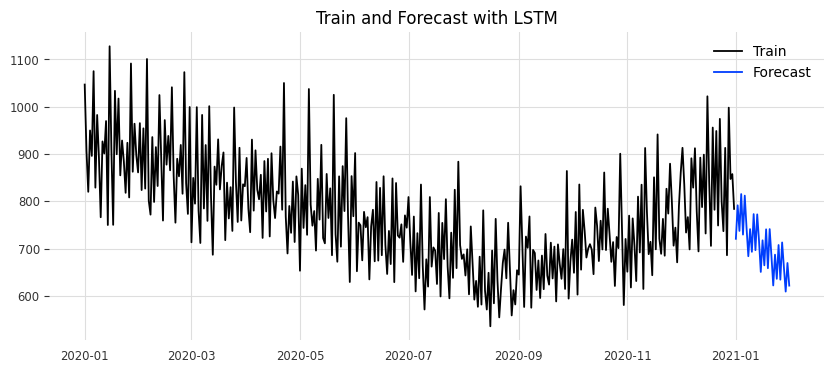

In [83]:
plot_future(df.y['2020':], predictions, "LSTM")